In [1]:
#当采用交叉熵,在train函数中:
#_,prediction = torch.max(F.softmax(prediction.data), 1),_代表的是概率值
#_,prediction = torch.max(prediction.data, 1),_代表的不是是概率值
#注意outputs = model(inputs)的outputs为Variable,而用于torch.max中的应为Tensor
#_, preds = torch.max(F.softmax(outputs.data), 1)
#局部微调:
#model = torchvision.models.resnet18(pretrained=True)
#for param in model.parameters():
    #param.requires_grad = False
#model.fc = nn.Linear(512, 100)
#a = torch.from_numpy(a)

In [2]:
# Author: 孙立波 created on 2018-04-01

In [3]:
##############################环境设置#######################
import torch
import pretrainedmodels

from torch.autograd import Variable ## torch中自动计算梯度模块
import torch.nn as nn # 神经网络模块
import torch.utils.data as data
import torch.nn.functional as F  #神经网络模块中的常用功能 
import torch.multiprocessing as mp
from torch import optim
from torch.optim import *
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader,Dataset

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torchvision import datasets, models
from torchvision.models import *

from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import time
import os
import copy
from tqdm import tqdm
import pandas as pd
from skimage import io, transform
from PIL import Image

%matplotlib inline
plt.ion()   # interactive mode
%config InlineBackend.figure_format = 'retina'

#显示中文字体设置
plt.rcParams["font.sans-serif"] = ["Droid Sans Fallback"]
plt.rcParams['axes.unicode_minus'] = False #为了正常显示是"-"减号

In [4]:
############################## 准备 #######################
#MODELS=[ 'nasnetalarge','inceptionresnetv2', 'inceptionv4', 'resnext101_64x4d', 'dpn131', 'dpn98',  'xception']
#MODELS=[ 'nasnetalarge','inceptionresnetv2', 'inceptionv4']
MODELS=[ 'nasnetalarge']
#OPTIMIZERS = {"SGD":SGD,"ASGD":ASGD,"Adam":Adam,"Adagrad":Adagrad}
OPTIMIZERS = {"Adam":Adam,"Adagrad":Adagrad}
# classes = [ 'collar_design_labels','neckline_design_labels','skirt_length_labels', 
#             'sleeve_length_labels', 'neck_design_labels', 'lapel_design_labels', 
#             'pant_length_labels','coat_length_labels']   
#classes = ['collar_design_labels', 'neckline_design_labels', 'neck_design_labels'] 
classes = ['neck_design_labels'] 
label_count = {'coat_length_labels':8,
               'collar_design_labels':5, 
               'lapel_design_labels':5,
               'neck_design_labels':5,
               'neckline_design_labels':10,
               'pant_length_labels':6, 
               'skirt_length_labels':6, 
               'sleeve_length_labels':9}

attrs_cls_label_map = {
    'skirt_length_labels':['群不可见Invisible', '短群Short', '及膝群Knee', '旗袍裙群Midi', '及脚群Ankle', '接地群Floor'],
    'coat_length_labels': ['衣不可见Invisible','高腰衣HighWaistLength','常规衣RegularLength','长衣LongLength','加长衣MicroLength',
                           '及膝衣Knee Length','旗袍衣MidiLength','及地衣Ankle&FloorLength'],
    'collar_design_labels': ['衣领不可见Invisible','衬衫领ShirtCollar','彼得潘女士小圆领PeterPan','清道夫领PuritanCollar','螺纹领RibCollar'],
    'lapel_design_labels':['翻领不可见Invisible','缺口领Notched','无领Collarless','披肩围巾式领ShawlCollar','大号披肩围巾式领PlusSizeShawl'],
    'neck_design_labels':['脖颈不可见Invisible','长高领TurtleNeck', '荷叶半高领RuffleSemi-HighCollar','低圆领LowTurtleNeck','翻领Draped Collar'],
    'neckline_design_labels':['颈领线不可见Invisible','无肩带领StraplessNeck','深V领DeepVNeckline', '直领StraightNeck', 'V领VNeckline', 
                              '方领SquareNeckline', '出肩领OffShoulder', '圆领RoundNeckline', '桃形领SweatHeartNeck', '单肩领OneShoulderNeckline'],
    'pant_length_labels':[ '裤不可见Invisible', '短裤ShortPant', '中裤Mid Length', '7分裤3/4Length', '9分裤CroppedPant', '长裤FullLength'],
    'sleeve_length_labels':['袖不可见Invisible', '无袖Sleeveless', '杯袖CupSleeves', '短袖ShortSleeves', '肘中袖ElbowSleeves',
                            '7分袖Sleeves', '及腕9分袖WristLength', '长袖LongSleeves', '超长袖ExtraLongSleeves']}


In [5]:
############################## 参数设置 #######################

#参数设置

#设置可见的GPU数,注意不是并行训练的设置
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1" 
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
#若gpu可用则返回True
use_gpu = torch.cuda.is_available()


        #sgd = SGD(lr=0.01, decay=0.01/45, momentum=0.9, nesterov=True)
        #adam = optimizers.Adam(lr=1e-4)
        #optimizer=sgd(lr=0.001, momentum=0.9, nesterov=True))
        #adam = Adam(lr=0.0001)
#保存文件后缀,即月份和日为版本尾号
#version = ""
version = 'outside-nasnet'
#learning_rate = 0.01,stepepochs_gamma =0.5,epochs_num = 60,scheduler_step_size = 10
image_width = 331
epochs_num = 30
scheduler_step_size = 10#设置含参变量的学习率变化，为多少个epoch做一次步进的衰减
learning_rate = 0.0001 
split_ratio = 0.2
batch_size = 64
stepepochs_gamma =0.5



train,val,test的一个batch输出shape分别为：
train# 1个batch图像数据： torch.Size([4, 3, 331, 331]) 1个batch的labels： torch.Size([4])
val# 1个batch图像数据： torch.Size([4, 3, 331, 331]) 1个batch的labels： torch.Size([4])
test# 1个batch图像数据： torch.Size([4, 3, 331, 331])

Attr:neck_design_labels.Train样本数：4556 ，Val样本数：1139，Test样本数：708


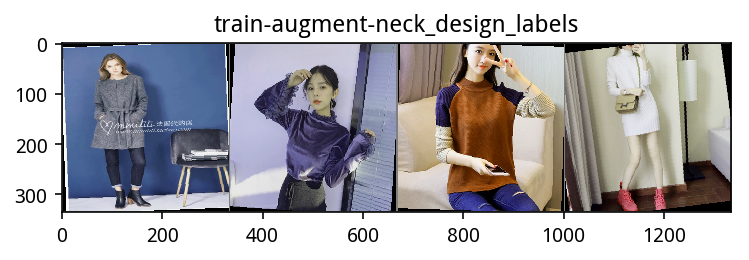

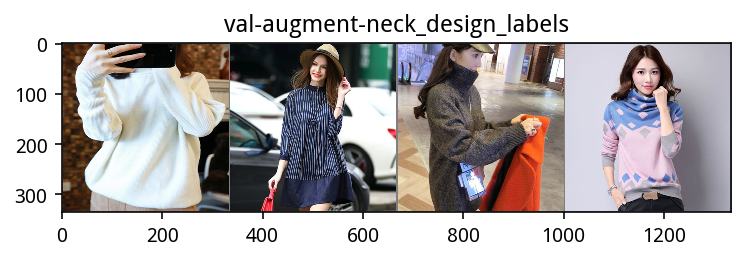

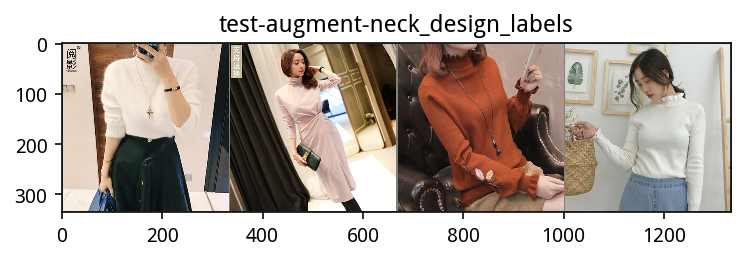

In [6]:
########################### 定义数据集类和预处理类及操作和数据集实例化测试 #######################

######################################################################################
#Data augmentation and normalization for training,Just normalization for validation

#Transforms on PIL Image
#过时class torchvision.transforms.Scale(size, interpolation=2) #按照规定的尺寸重新调节PIL.Image
#class torchvision.transforms.Resize(size, interpolation=2)
#class torchvision.transforms.CenterCrop(size) #将给定的PIL.Image进行中心切割，得到给定的size，size可以是tuple，(target_height, target_width)。size也可以是一个Integer，在这种情况下，切出来的图片的形状是正方形
#class torchvision.transforms.RandomCrop(size, padding=0) #切割中心点的位置随机选取。size可以是tuple也可以是Integer。
#class torchvision.transforms.RandomHorizontalFlip(p=0.5) #随机水平翻转给定的PIL.Image,概率为0.5。即：一半的概率翻转，一半的概率不翻转。
#过时class torchvision.transforms.RandomSizedCrop(size, interpolation=2) #先将给定的PIL.Image随机切，然后再resize成给定的size大小。
#class torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
#class torchvision.transforms.FiveCrop(size) #可能不匹配batchsize，见官网。Crop the given PIL Image into four corners and the central crop
#class torchvision.transforms.TenCrop(size, vertical_flip=False)
#class torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0) #Randomly change the brightness, contrast and saturation of an image.
#class torchvision.transforms.RandomRotation(degrees, resample=False, expand=False, center=None)
#class torchvision.transforms.RandomAffine(degrees, translate=None, scale=None, shear=None, resample=False, fillcolor=0)

#Transforms on torch.*Tensor
#class torchvision.transforms.Normalize(mean, std) #给定均值：(R,G,B) 方差：（R，G，B），将会把Tensor的每个通道矩阵值规范化到正态分布上。即：Normalized_image=(image-mean)/std。

#Conversion Transforms
#class torchvision.transforms.ToTensor #Convert a PIL Image or numpy.ndarray to tensor.如把一个取值范围是[0,255]的PIL.Image或者shape为(H,W,C)的numpy.ndarray，转换成形状为[C,H,W]，取值范围是[0.0,1.0]的torch.FloadTensor
#class torchvision.transforms.ToPILImage(mode=None)

#class torchvision.transforms.Lambda(lambd) #使用转换器
#Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops]))

#应加入的数据增强：对fai一定不要用transforms.RandomCrop(size, padding=0)
#transforms.Resize(image_width, interpolation=2) #一般放缩到224*224，并保持边长比不变
#transforms.RandomHorizontalFlip(p=0.65) #这个很有用！！！
#transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.2) #是随机的，赋值为增益因子
#transforms.RandomRotation(20, resample=False, expand=False, center=None)

#可能轻微的影响transforms.RandomResizedCrop(image_width, scale=(0.95, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
#可能会有用，可用于测试阶段transforms.CenterCrop((224,180))，如：transforms.CenterCrop(256，224)#注意不是随机裁剪，即高不变，裁剪的宽变化

################################################################################
#注：定义的dataset经自定义的transform或库自带的基于PIL的数据变换返回的图像和label都应是Tensor形式，而用库自带的变换，需用PIL读取图像！

#定义数据预处理

#######################transforms.RandomRotation(10)#改变10度
        ###############################transforms.ColorJitter(0.05, 0.05, 0.05, 0.05)#微小抖动
fai_data_transforms = {
                    'train': transforms.Compose([
                        transforms.Resize(image_width, interpolation=2),
                        transforms.RandomHorizontalFlip(),
                        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                        transforms.RandomRotation(10, resample=False, expand=False, center=None),
                        transforms.RandomResizedCrop(image_width, scale=(0.95, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
                        
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                    ]),
                    'val': transforms.Compose([
                        #transforms.Resize(256),
                        #transforms.CenterCrop(256,224),
                        transforms.Resize(image_width, interpolation=2),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                    ]),
                    'test': transforms.Compose([
                        #transforms.Resize(256),
                        #transforms.CenterCrop(256,224),
                        transforms.Resize(image_width, interpolation=2),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                    ])
}

#定义数据集
#当变换中含有 transforms.ToTensor(),处理后为RGB CHW 0-1.0数据，当含有transforms.Normalize()会返回一个分布在(x-mean)/std,这时值的范围就不是0-1.0了
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB').resize((image_width,image_width),Image.ANTIALIAS)

def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)

def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)
#定义数据集
class FaiTrainDataset(Dataset):
    """FaiTrainDataset dataset."""

    def __init__(self, train_csv_path_and_file, train_val_images_root_dir, train =True, split_ratio=0.2,transform=None,target_transform=None,loader=default_loader):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(train_csv_path_and_file)
        #self.df_load = df.sample(frac=1).reset_index(drop=True)
        self.df_load = self.df.copy()
        #df.iloc[np.random.permutation(len(df))]
        self.split_ratio = split_ratio
        self.cut_idx = int(len(self.df_load)-round(len(self.df_load)*self.split_ratio))#int(round(0.1 * self.df_load.shape[0]))
        self.df_train= self.df_load.iloc[:self.cut_idx]
        self.df_val = self.df_load.iloc[self.cut_idx:]
        
        self.df_train_load = self.df_train.copy()
        self.df_val_load = self.df_val.copy()
        
        self.df_train_load.columns = ['image_id', 'class', 'label']
        self.df_val_load.columns = ['image_id', 'class', 'label']
        
        self.df_train_load.reset_index(inplace= True,drop=True)
        self.df_val_load.reset_index(inplace= True,drop=True)
        
        self.train_images = self.df_train_load['image_id'].tolist()
        self.train_labels = self.df_train_load['label'].tolist()
        
        self.val_images = self.df_val_load['image_id'].tolist()
        self.val_labels = self.df_val_load['label'].tolist()
        
        n1=len(self.df_train_load)
        n2=len(self.df_val_load)
        
        #不用转化为one-hot，根据所用的交叉熵形式
        #self.train_y = np.zeros((n1, label_count[self.df_train_load['class'][0]]), dtype=np.uint8)
        #self.val_y = np.zeros((n2, label_count[self.df_val_load['class'][0]]), dtype=np.uint8)
        self.train_y = np.zeros(n1, dtype=np.uint8)
        self.val_y = np.zeros(n2, dtype=np.uint8)
        
        for i in range(n1):
            tmp_label1=self.train_labels[i]
            self.train_y[i]=tmp_label1.find('y')
        for j in range(n2):
            tmp_label2=self.val_labels[j]
            self.val_y[j]=tmp_label2.find('y')
        self.train_data = list(zip(self.train_images,self.train_y))
        self.val_data = list(zip(self.val_images,self.val_y))
        #print("训练集：batch化需要的元组样例是{0}：".format(self.train_data[0]))
        #print("验证集：batch化需要的元组样例是{0}：".format(self.val_data[0]))
        
        self.train_val_images_root_dir = train_val_images_root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.train = train

    def __len__(self):
        if self.train == True:
            return len(self.df_train_load)
        else:
            return len(self.df_val_load)

    def __getitem__(self, index): #最终返回的是Tensor
        if self.train == True:
            train_image_path, train_label = self.train_data[index]
            train_img_name = os.path.join(self.train_val_images_root_dir,train_image_path)
            #image = io.imread(img_name) #用的skimage.io,读入为uint8，RGB，HWc图像
            train_img = self.loader(train_img_name)
            
            if self.transform is not None:
                train_img = self.transform(train_img) #处理后为RGB CHW ，个位整数的数据
            if self.target_transform is not None:
                train_label = self.target_transform(train_label)
            return train_img,train_label
        else:
            val_image_path, val_label = self.val_data[index]
            val_img_name = os.path.join(self.train_val_images_root_dir,val_image_path)
            #image = io.imread(img_name) #用的skimage.io,读入为uint8，RGB，HWc图像
            val_img = self.loader(val_img_name)
            
            if self.transform is not None:
                val_img = self.transform(val_img) ##处理后为RGB CHW ，个位整数的数据
            if self.target_transform is not None:
                val_label = self.target_transform(val_label)
            return val_img,val_label #返回值是Tensor
            
#定义测试数据集
class FaiTestDataset(Dataset):
    """FaiTestDataset dataset."""

    def __init__(self, test_csv_path_and_file, test_images_root_dir, attr, transform=None,target_transform=None,loader=default_loader):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
       
        self.df_test = pd.read_csv(test_csv_path_and_file)
        #定义各列名称
        self.df_test.columns = ['image_id', 'class', 'x']
        del self.df_test['x']
        self.attr = attr
        
        self.df_test_load = self.df_test[(self.df_test['class'] == self.attr)].copy()
        self.df_test_load.reset_index(inplace= True,drop= True)
        
        self.test_images = self.df_test_load['image_id'].tolist()
        #n=len(self.df_test_load)
        #self.test_y = np.zeros((n, label_count[self.attr]), dtype=np.uint8)
        #self.test_data = list(zip(self.test_images,self.test_y))
        self.test_data = self.test_images
        #print("测试集（不含label）：batch化需要的元组样例是{0}：".format(self.test_data[0]))
    
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.test_images_root_dir = test_images_root_dir
    
    def __len__(self):
        return len(self.df_test_load)

    def __getitem__(self, index):
        test_path = self.test_data[index]
        test_img_name = os.path.join(self.test_images_root_dir,test_path)
        #test_image = io.imread(test_img_name) 只能用PIL读图像，因为系统要求
        test_img = self.loader(test_img_name)
            
        if self.transform is not None:
            test_img = self.transform(test_img) #处理后为RGB CHW ，个位整数的数据

        return test_img #返回值为Tensor

################################################## 对定义的数据集做测试  以classes[0]属性为例 ####################
#定义的dataset经自定义的transform或库自带的基于PIL的数据变换返回的图像和label都应是Tensor形式，而用库自带的变换，需用PIL读取图像！
#测试训练，验证和测试数据上的数据增强
fai_train_dataset = FaiTrainDataset(train_csv_path_and_file='../train/Annotations/{0}.csv'.format(classes[0]),
                                   train_val_images_root_dir='../train/',
                                   train =True, split_ratio=split_ratio,
                                   transform = fai_data_transforms['train'])
fai_val_dataset = FaiTrainDataset(train_csv_path_and_file='../train/Annotations/{0}.csv'.format(classes[0]),
                                   train_val_images_root_dir='../train/',
                                   train =False, split_ratio=split_ratio,
                                   transform = fai_data_transforms['val'])

image_datasets = {'train': fai_train_dataset, 'val':fai_val_dataset}

#关于训练验证集
dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=4,shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=4,shuffle=False, num_workers=4),
              }
dataset_lengths = {x: len(image_datasets[x]) for x in ['train', 'val']}

#关于测试集
fai_test_dataset = FaiTestDataset(test_csv_path_and_file='../test/Tests/question.csv',
                                  test_images_root_dir='../test/',
                                  attr =classes[0],
                                  transform = fai_data_transforms['test'])

test_dataloader = torch.utils.data.DataLoader(fai_test_dataset, batch_size=4,shuffle=False, num_workers=4)
test_dataset_length = len(fai_test_dataset)
       
print()         
# print("dataloaders['train']的一个batch输出为：")
# print(next(iter(dataloaders['train'])))
# print("dataloaders['val']的一个batch输出为：")
# print(next(iter(dataloaders['val'])))
# print("test_dataloader的一个batch输出为：")
# print(next(iter(test_dataloader)))

print()
print("train,val,test的一个batch输出shape分别为：")
train_sample1,train_sample2= next(iter(dataloaders['train']))
print("train#",'1个batch图像数据：',train_sample1.size(),'1个batch的labels：',train_sample2.size())
val_sample1,val_sample2= next(iter(dataloaders['val']))
print("val#",'1个batch图像数据：',val_sample1.size(),'1个batch的labels：',val_sample2.size())
test_sample1= next(iter(test_dataloader))
print("test#",'1个batch图像数据：',test_sample1.size())
    
print()

#测试定义的数据,一个batch的数据可视化
def fai_augment_visualize(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) #若用cv显示则是：inp = inp.numpy().transpose((1, 2, 0))*255 
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(0.001)  # pause a bit so that plots are updated
    # opencv
    #img2 = data[i][0].numpy()*255
    #img2 = img2.astype('uint8')
    #img2 = np.transpose(img2, (1,2,0))
    #img2=img2[:,:,::-1]#RGB->BGR
    #cv2.imshow('img2', img2)
    #cv2.waitKey()
print("Attr:{0}.Train样本数：{1} ，Val样本数：{2}，Test样本数：{3}".format(classes[0],len(fai_train_dataset),len(fai_val_dataset),len(fai_test_dataset)))
#torch.utils.data.DataLoader是一个提供功能的迭代器。其中一个蛮有趣的参数是collate_fn。
#可用collate_fn来指定如何读取一批的样本。然而，默认的collate在大部分的情况下都表现得很好。
# Get a batch of training data
inputs1, classes1 = next(iter(dataloaders['train']))
inputs2, classes2 = next(iter(dataloaders['val']))
inputs3 = next(iter(test_dataloader))
# Make a grid from batch and visualize输出
plt.figure(0)
out1 = torchvision.utils.make_grid(inputs1) #为CHW，RGB 0.0-1.0图像，用plt显示需转化为HWC形式
fai_augment_visualize(out1, title='train-augment-{0}'.format(classes[0]))
plt.figure(1)
out2 = torchvision.utils.make_grid(inputs2)
fai_augment_visualize(out2, title='val-augment-{0}'.format(classes[0]))
plt.figure(3)
out3 = torchvision.utils.make_grid(inputs3)
fai_augment_visualize(out3, title='test-augment-{0}'.format(classes[0]))

In [7]:
########################### 定义训练和测试及其他可视化函数 #######################
#定义训练模型的具体步骤及参数设置
def fai_train_model(model, criterion, optimizer, scheduler, batch_size,split_ratio,num_epochs,attr,model_key,version):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    #测试训练，验证和测试数据上的数据增强
    training_fai_train_dataset = FaiTrainDataset(train_csv_path_and_file='../train/Annotations/{0}.csv'.format(attr),
                                       train_val_images_root_dir='../train/',
                                       train =True, split_ratio=split_ratio,
                                       transform= fai_data_transforms['train'])
    training_fai_val_dataset = FaiTrainDataset(train_csv_path_and_file='../train/Annotations/{0}.csv'.format(attr),
                                       train_val_images_root_dir='../train/',
                                       train =False, split_ratio=split_ratio,
                                       transform= fai_data_transforms['val'])
    training_image_datasets = {'train': training_fai_train_dataset, 'val':training_fai_val_dataset}

    #关于训练验证集的封装
    training_dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=4,shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=4,shuffle=False, num_workers=4),
               }
    training_dataset_lengths = {x: len(training_image_datasets[x]) for x in ['train', 'val']}
    print("摘要：Attr:{0}.Train样本数：{1} ，Val样本数：{2}".format(attr,training_dataset_lengths['train'],training_dataset_lengths['val']))
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            #每batch一次train，就val一次
            if phase == 'train':
                #与Optimizer类似的是，其主要功能体现在step()方法中，用于更新optimizer对象每个param_group字典的lr键的值。
                #scheduler = torch.optim.ReduceLROnPlateau(optimizer, 'min')，这应用在函数体外
                #scheduler.step() #
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in training_dataloaders[phase]:
                # get the inputs(每次一个batch)
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.long().cuda())
                else:
                    inputs, labels = Variable(inputs,volatile=True), Variable(labels,volatile=True)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                #_, preds = torch.max(F.softmax(utputs.data), 1)
                _, preds = torch.max(outputs.data, 1) #第一个是最大值的张量(注意此处不是概率值)，第二个是索引值
                
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                # 即用的总loss而不是平均loss
                running_loss += loss.data[0] * inputs.size(0) #inputs.size(0)：每个batchsize的大小
                running_corrects += torch.sum(preds == labels.data) #可知标签不用转化为one-hot
               
            epoch_loss = running_loss / training_dataset_lengths[phase]
            epoch_acc = running_corrects / training_dataset_lengths[phase]
            #if phase == 'val':
                #scheduler.step(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    #保存最好的模型
    print("开始保存模型")
    prefix_cls = attr.split('_')[0]
    PATH = '../models/{0}/pytorch_{0}_{1}_{2}'.format(prefix_cls, model_key, version)
    torch.save(model.state_dict(), PATH)
    #model = 你定义的模型class封装
    #model.load_state_dict(torch.load(PATH))
    print("保存最好的模型完成")
    
    return model

######这是将训练好的模型用于测试集上，输出对应属性的也测结果到csv文件
#CPU版本的函数
def fai_predict(predictor,attr,model_key,version): 
    fai_test_dataset = FaiTestDataset(test_csv_path_and_file='../test/Tests/question.csv',
                                      test_images_root_dir='../test/',
                                      attr =attr,
                                      transform= fai_data_transforms['test'])
    
    test_dataloader = torch.utils.data.DataLoader(fai_test_dataset, batch_size=32,shuffle=False, num_workers=4)
    
    model = predictor.cpu()
    model.train(False)
    model.eval() #model.train(False)  # Set model to evaluate mode
    #len(test_dataloader)返回的是len(相应dataset)/batch_size
    #for i_batch in tqdm(range(len(test_dataloader))):
    #在测试集上预测并保存结果
    df_test_load = fai_test_dataset.df_test_load
    print("测试属性：Attr:{0}".format(attr))
    print('测试数据集的样本数为：{0},迭代器需要的迭代次数是：{1}次batchsize的迭代'.format(len(fai_test_dataset),len(test_dataloader)))
    
    result = []
    prefix_cls = attr.split('_')[0]
    for i,batch_x in enumerate(test_dataloader):
        batch_x = Variable(batch_x, volatile=True)
        out = model(batch_x)
        out = F.softmax(out,dim=1) #把输出的正负数转到0-1之间
        test_np=out.data.numpy()
        
        #tmp_list = test_np.tolist()
        for jj in test_np:
            
            tmp_result = ''
            for tmp_ret in jj:
                tmp_result += '{:.5f};'.format(tmp_ret)
                #不要最后一个分号
            result.append(tmp_result[:-1])
    
    #预测结果导入内存表格的result列
    df_test_load['result'] = result     
    df_test_load.to_csv('../result/pytorch/pytorch_{0}_{1}_{2}.csv'.format(prefix_cls, model_key, version), header=None, index=False) 
    print('#######完成{0}:{1}下的测试集上的csv文件输出'.format(model_key,attr))
        
######这是可视化预测输出函数，用于测试集上的预测可视化，测试一个batch的输出（设置batchsize大小的是n_pictures）
#predictor：模型分类器#attr：要测试的属性#n_pictures：要测试的图片数,最好别大于8,因为输出为1*n的形式
#CPU+cuda版本的函数
def fai_predict_test_data_visualize(predictor, attr, n_pictures=8,use_gpu= False):
    fai_test_dataset = FaiTestDataset(test_csv_path_and_file='../test/Tests/question.csv',
                                  test_images_root_dir='../test/',
                                  attr =attr,
                                  transform= fai_data_transforms['test'])
    test_dataloader = torch.utils.data.DataLoader(fai_test_dataset, batch_size=n_pictures,shuffle=False, num_workers=4)
    test_dataset_length = len(fai_test_dataset) #注：len(test_dataloader)返回的是len(相应dataset)/batch_size
    if use_gpu:
        model = predictor.cuda()
        model.train(False)
        model.eval()
    else:
        
        model = predictor.cpu()
        model.train(False)
        model.eval()
    # get some random training images
    dataiter = iter(test_dataloader)
    batch_x= dataiter.next()
    if use_gpu:
        batch_xx = Variable(batch_x.cuda(), volatile=True)
    else:
        batch_xx = Variable(batch_x,volatile=True)  
    outputs = model(batch_xx)
    _, predicted = torch.max(outputs.data, 1) #此时predicted为Tensor类型的索引列表

    if use_gpu:
        aa = predicted.cpu().numpy()
    else:
        aa = predicted.numpy()
    fig,axes = plt.subplots(ncols=n_pictures,figsize=(4*n_pictures,4))  
    print('{0}张图片预测得到的索引:'.format(n_pictures))
    print(aa)
    for i in range(n_pictures):
        """Imshow for Tensor."""
        inp = batch_x[i].numpy().transpose((1, 2, 0)) #若用cv显示则是：inp = inp.numpy().transpose((1, 2, 0))*255 
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        k = aa[i]
        axes[i].set_title("pred-vis-{0},\nPred:{1}".format(attr,attrs_cls_label_map[attr][k]),color='r')  
        axes[i].imshow(inp)
    print('完成测试集上的一个batchsize测试!')
    #plt.savefig('../images/{0}/pytorch_{0}_{1}_{2}.png'.format(prefix_cls, KEY, version),bbox_inches='tight')

In [8]:
################################### 迁移学习添加新层 ############################

# class FAINET(nn.Module): #model为需要finetune的base model,对于resnet最后两层分别为pooling和fc,此模型只去除最后一层,然后做一定的修改
#     def __init__(self, model,fai_classes_num, hidden_feature_size = 512): #,classes_num为分类数,hidden_feature_size是三层全连接间的隐藏层神经元个数,属于倒数第二层数

#         super(FAINET, self).__init__() 
#         #self.fai_base_features = nn.Sequential(*list(model.children())[:-2])
#         self.fai_base_features = nn.Sequential(*list(model.children())[:-1])#即去除最后一层全连接层(一般是由卷积得来的2048维),*是解包操作
#         #若不让输出保证与原模型一样可用:
#         #self.fai_num_ftrs = 2048 #特征图数 #
#         self.fai_num_ftrs = model.last_linear.in_features #原模型的fc-Module输入维度,in_features为Linear类的输入参数
#         #下面是新增的操作
# #         self.fai_conv =nn.Sequential(
# #                         nn.Conv2d(self.fai_num_ftrs, 32, kernel_size=4, stride=1, padding=2), # in:如(bs,self.fai_num_ftrs,60,160)
# #                         nn.BatchNorm2d(32),
# #                         nn.LeakyReLU(0.2, inplace=True),     
# #                         nn.MaxPool2d(kernel_size=2),        # out:(bs,32,30,80)
                        
# #                         nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=2),
# #                         nn.BatchNorm2d(64),
# #                         nn.LeakyReLU(0.2, inplace=True),
# #                         nn.MaxPool2d(kernel_size=2),        # out:(bs,64,15,40)
                        
# #                         nn.Conv2d(64, 64, kernel_size=3 ,stride=1, padding=1),
# #                         nn.BatchNorm2d(64),
# #                         nn.LeakyReLU(0.2, inplace=True),     
# #                         nn.MaxPool2d(kernel_size=2)         # out:(bs,64,7,20)
# #                     )
#         self.fai_end_classifier = nn.Sequential(
#             nn.BatchNorm1d(self.fai_num_ftrs),
#             nn.Linear(self.fai_num_ftrs, hidden_feature_size),
#             nn.BatchNorm1d(hidden_feature_size),
#             nn.ReLU(inplace=True),
#             nn.Linear(hidden_feature_size, fai_classes_num)
#             #在次加入softmax则部署模型时输出的是概率值,不过也可以不加,在预测的时候加入也可以做转化,影响不大
#         )
#     def forward(self, x):
#         x = self.fai_base_features(x)
#         #加入自定义的卷积层
#         #x = self.fai_conv(x)
#         #加入全局池化
#         #x = F.average_pool2d(x, kernel_size=input.size()[2:]) #加全局均值采样得到的是batch-size*特征图的个数
#         #其实若加入了全局卷积池化就不用展平操作了
#         x = x.view(x.size(0), -1) #相当于numpy的reshape和keras的Flatten层,将二维压成一维
#         x = self.fai_end_classifier(x)
#         return x
    
        #x = Dropout(0.5)(x)
        #x = Flatten(name='flatten')(x)
        #x = Dense(1024, activation='relu', name='fc1')(x)
        # n_class为对应属性的分类个数
        #x = Dense(512, activation='relu', kernel_initializer=initializers.he_uniform(seed=None),name='fc2')(x)
        #x = Dropout(0.5)(x)
        #x = Dense(n_class, activation='softmax', name='softmax')(x)

In [9]:
################################### 实例化训练和测试 ############################
#加载预训练模型并重写全连接层。

#state_dict = torch.utils.model_zoo.load_url('https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth')
#the_model = TheModelClass(*args, **kwargs)
#the_model.load_state_dict(torch.load(PATH))

#下面是冻结卷积层的方法
# fai_model = torchvision.models.resnet18(pretrained=True)
# for param in fai_model.parameters():
#     param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
#model.fc = nn.Linear(512, 100)
# Optimize only the classifier
#optimizer = optim.SGD(model.fc.parameters(), lr=1e-2, momentum=0.9)
for KEY in MODELS:
    print('######################在{0}下训练8个分类器####################'.format(KEY))
    print()
    for KEY2,OPTIMIZER in OPTIMIZERS.items():
        print('######################在{0}:{1}下训练8个分类器####################'.format(KEY,KEY2))
        print()
        for cur_class in classes:

            print('#######{0}:{1}:{2}####################'.format(KEY,KEY2, cur_class))
            #预结构
            fai_model = pretrainedmodels.__dict__[KEY](num_classes=1000, pretrained='imagenet')
            dim_feats = fai_model.last_linear.in_features # =2048
            nb_classes = label_count[cur_class]
            fai_model.last_linear = nn.Linear(dim_feats, nb_classes)
            #打印含参数各层的名字
            #params = fai_model.state_dict()
            #for k,v in params.items():
            #    print(k)#打印网络中的变量名
            #print(fai_model)#可查最后一层Module类对象的名和输入参数，输出参数名，如(fc): Linear(in_features=512, out_features=5, bias=True)


            if use_gpu:
                #If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
                fai_model = fai_model.cuda()
                #多GPU训练用:
                #fai_model = torch.nn.DataParallel(module=fai_model.cuda(), device_ids=[0, 3],output_device=0).cuda()#前向在 device_ids，梯度汇总和更新在output_device上
            #设置采用多分类的交叉熵loss
            criterion = nn.CrossEntropyLoss()

            # 设置优化器，fai_model.parameters()表示优化全部参数@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@这里可设置两部优化法
            #torch.optim.Adadelta(params, lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
            #torch.optim.Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0)
            #torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
            #torch.optim.SparseAdam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
            #class torch.optim.Adamax(params, lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
            #class torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
            #torch.optim.Rprop(params, lr=0.01, etas=(0.5, 1.2), step_sizes=(1e-06, 50))
            #torch.optim.SGD(params, lr=<object object>, momentum=0, dampening=0, weight_decay=0, nesterov=False)
            optimizer = OPTIMIZER(fai_model.parameters(), lr=learning_rate)
            #optimizer = optim.Adam(ai_model.parameters(), lr = learning_rate)#olearning_rate=0.0001,optimizer = optim.Adam([var1, var2], lr = 0.0001)


            # Decay LR by a factor of 0.1 every 7 epochs
            #与Optimizer类似的是，其主要功能体现在step()方法中，用于更新optimizer对象每个param_group字典的lr键的值。
            #scheduler = torch.optim.ReduceLROnPlateau(optimizer, 'min')   scheduler.step(val_loss)
            fai_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=stepepochs_gamma) 
            #fai_lr_scheduler = ReduceLROnPlateau(optimizer, 'max',patience=10,factor = 0.1,verbose = False)

            #训练和评估
            model = fai_train_model(fai_model, criterion, optimizer, fai_lr_scheduler, batch_size=batch_size,split_ratio=split_ratio,num_epochs=epochs_num,attr=cur_class,model_key=KEY,version=version)
            #在测试集上运用训练好的模型，输出csv文件
            print('#######{0}:{1}训练完毕，开始在测试集上测试'.format(KEY,cur_class ))
            #在cpu上测试
            model = model.cpu()
            fai_predict(predictor = model,attr=cur_class,model_key=KEY,version=version)
            #fai_predict_test_data_visualize(predictor= model, attr=cur_class, n_pictures=8,use_gpu= False)

######################在nasnetalarge下训练8个分类器####################

######################在nasnetalarge:Adam下训练8个分类器####################

#######nasnetalarge:Adam:neck_design_labels####################
摘要：Attr:neck_design_labels.Train样本数：4556 ，Val样本数：1139
Epoch 0/29
----------
train Loss: 0.9449 Acc: 0.6576
val Loss: 0.6558 Acc: 0.7726

Epoch 1/29
----------
train Loss: 0.5627 Acc: 0.8095
val Loss: 0.6140 Acc: 0.7919

Epoch 2/29
----------
train Loss: 0.4096 Acc: 0.8580
val Loss: 0.6803 Acc: 0.7621

Epoch 3/29
----------
train Loss: 0.3295 Acc: 0.8914
val Loss: 0.6312 Acc: 0.7998

Epoch 4/29
----------
train Loss: 0.2584 Acc: 0.9122
val Loss: 0.8501 Acc: 0.7858

Epoch 5/29
----------
train Loss: 0.2278 Acc: 0.9284
val Loss: 0.9439 Acc: 0.7682

Epoch 6/29
----------
train Loss: 0.1962 Acc: 0.9381
val Loss: 0.6887 Acc: 0.8016

Epoch 7/29
----------
train Loss: 0.1646 Acc: 0.9458
val Loss: 0.7578 Acc: 0.7989

Epoch 8/29
----------
train Loss: 0.1462 Acc: 0.9550
val Loss: 0.8788 Acc: 0.7744



Process Process-446:
Process Process-447:
Process Process-448:
Process Process-445:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/slb/anaconda2/envs/py36_pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/slb/anaconda2/envs/py36_pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/slb/anaconda2/envs/py36_pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/slb/anaconda2/envs/py36_pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/slb/anaconda2/envs/py36_pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/slb/anaconda2/envs/py36_pytorch/lib/python3.6/site-packages/torch/utils/data/data

KeyboardInterrupt: 

In [ ]:
##############################模型实例部署并进行可视化测试#############################################
#自定义载入相应模型来自finetune或者是model来自你定义的模型class封装，并进行可视化测试

#下面是finetune示例
#KEY = finetune改进的模型类型，在此为对应的字符串
#预结构
#fai_model = models.MODELS[KEY](pretrained=True)
#改进的自定义添加
#num_ftrs = fai_model.fc.in_features
#fai_model.fc = nn.Linear(num_ftrs, label_count[cur_class])

#prefix_cls = classes[0].split('_')[0]
#PATH = '../models/{0}/pytorch_{0}_{1}_{2}'.format(prefix_cls, model_key=KEY, version=version)
#torch.save(model.state_dict(), PATH)
#装入训练好的模型的权重
#model.load_state_dict(torch.load(PATH))
#fai_predict_test_data_visualize(predictor = fai_model, classes[0], n_pictures = batch_size,use_gpu= False):